In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from natsort import natsorted


In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in natsorted(os.listdir(folder)):
        if filename.endswith('.tiff'):
            img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib
            if img is not None:
                images.append(img)

    return images

    
def plot_images(imgs, figsize_in_inches=(20,20)):
    fig, axs = plt.subplots(1, len(imgs), figsize=figsize_in_inches)
    for col, img in enumerate(imgs):
        axs[col].imshow(img)

    # Adjust the spacing
    plt.subplots_adjust(wspace=0.5)

In [4]:
def display_keypoints(image, keypoints):
    img_with_keypoints = np.copy(image)
    for kp in keypoints:
        x, y = kp.pt
        cv2.circle(img_with_keypoints, (int(x), int(y)), 5, (255, 0, 0), 1)

    plt.imshow(img_with_keypoints)
    plt.show()

def find_and_display_keypoints(image):
    sift = cv2.SIFT_create()
    keypoints, _ = sift.detectAndCompute(image, None)
    display_keypoints(image, keypoints)



In [14]:
def display_matches(img1, img2, kp1, kp2, matches):
    match_img = cv2.drawMatches(
        img1, kp1, img2, kp2, matches, None, 
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
        matchesThickness=7,
        matchColor=(0, 255, 0)
    )
    plt.figure(figsize=(10, 5))
    plt.imshow(match_img)
    plt.show()

def find_and_display_matches(img1, img2):
    sift = cv2.SIFT_create()
    kp1, desc1 = sift.detectAndCompute(img1, None)
    kp2, desc2 = sift.detectAndCompute(img2, None)

    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    
    # Check if either image has insufficient keypoints or descriptors
    if desc1 is None or desc2 is None or len(kp1) < 2 or len(kp2) < 2:
        print("Error: Not enough keypoints/descriptors in one or both images.")
        return kp1, kp2, []  # Return empty matches

    # Create the FLANN matcher and run KNN match
    matcher = cv2.FlannBasedMatcher(index_params, search_params)
    
    try:
        matches = matcher.knnMatch(desc1, desc2, k=2)
        # Apply Lowe's ratio test to filter good matches
        good_matches = []
        for m, n in matches:
            if m.distance < 0.25 * n.distance:
                good_matches.append(m)
        
        # Display matches before returning
        display_matches(img1, img2, kp1, kp2, good_matches)
        return kp1, kp2, good_matches

    except cv2.error as e:
        print(f"Error during matching: {e}")
        return kp1, kp2, []  # Return empty matches



In [13]:
def stitch_pair_with_affine(img1, img2, kp1, kp2, matches):
    min_matches = 15

    # If there are not enough keypoints or matches, use the 50% overlap approach
    if len(kp1) == 0 or len(kp2) == 0 or len(matches) < min_matches:
        print("Not enough keypoints or matches. Using 50% overlap for stitching.")
        return stitch_images_with_overlap_pair(img1, img2)

    # Otherwise, compute the affine transformation based on matches
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    M, _ = cv2.estimateAffinePartial2D(dst_pts, src_pts, method=cv2.RANSAC)

    # Apply the affine transformation and find the size of the transformed image
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    corners = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    transformed_corners = cv2.transform(corners, M)

    [x_min, y_min] = np.int32(transformed_corners.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(transformed_corners.max(axis=0).ravel() + 0.5)

    x_min = min(x_min, 0)
    y_min = min(y_min, 0)
    x_max = max(x_max, w1)
    y_max = max(y_max, h1)

    trans_mat = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])
    M_extended = np.vstack([M, [0, 0, 1]])
    M_translated = np.dot(trans_mat, M_extended)[:2]

    canvas_size = (x_max - x_min, y_max - y_min)
    img2_aligned = cv2.warpAffine(img2, M_translated, canvas_size)

    # Define a color for the empty space
    empty_space_color = np.array([0, 0, 0], dtype=np.uint8)

    # Create a new canvas and fill with the empty space color
    canvas = np.full((canvas_size[1], canvas_size[0], 3), empty_space_color, dtype=np.uint8)
    canvas[-y_min:h1-y_min, -x_min:w1-x_min] = img1

    # Identify the overlap by looking at non-black pixels
    overlap_area = np.logical_and(np.any(img2_aligned != 0, axis=-1), np.any(canvas != 0, axis=-1))

    # Blend the overlapping regions using direct array slicing
    canvas[overlap_area] = (canvas[overlap_area] * 0.5 + img2_aligned[overlap_area] * 0.5).astype(np.uint8)

    # Copy the non-overlapping region from img2_aligned to canvas
    non_overlap_mask = np.any(img2_aligned != 0, axis=-1) & ~overlap_area
    canvas[non_overlap_mask] = img2_aligned[non_overlap_mask]

    return canvas


def stitch_images_with_overlap_pair(img1, img2):
    # Ensure both images have the same width
    height1, width1 = img1.shape[:2]
    height2, width2 = img2.shape[:2]

    # Resize img2 to match the width of img1
    if width1 != width2:
        img2 = cv2.resize(img2, (width1, height2))

    # Ensure 50% overlap of the height
    overlap_height = height2 // 2

    # Crop the second image to remove the top half to achieve 50% overlap
    cropped_img2 = img2[overlap_height:, :]

    # Stack the first image with the cropped second image
    stitched_image = np.vstack((img1, cropped_img2))

    return stitched_image



In [7]:
import os
import cv2
import numpy as np
from natsort import natsorted
import matplotlib.pyplot as plt


def vertical_stitching_sequential(images):
    # Initialize the stitched image as the first image
    stitched_image = images[0]

    # Iterate over the remaining images and stitch them one by one
    for i in range(1, len(images)):
        img1 = stitched_image
        img2 = images[i]

        # Find keypoints and matches between img1 and img2
        kp1, kp2, good_matches = find_and_display_matches(img1, img2)
        
        # Stitch the images using either feature-based or fixed transformation
        stitched_image = stitch_pair_with_affine(img1, img2, kp1, kp2, good_matches)

        if stitched_image is None:
            print(f"Stitching failed at pair {i-1}, {i}.")
            return None

    return stitched_image

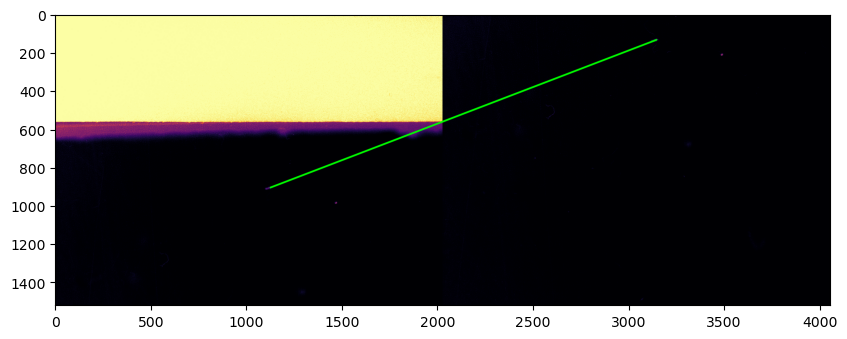

Not enough keypoints or matches. Using 50% overlap for stitching.


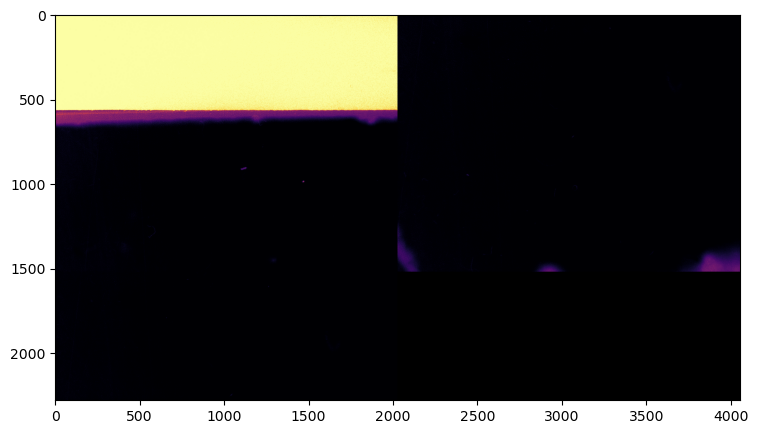

Not enough keypoints or matches. Using 50% overlap for stitching.


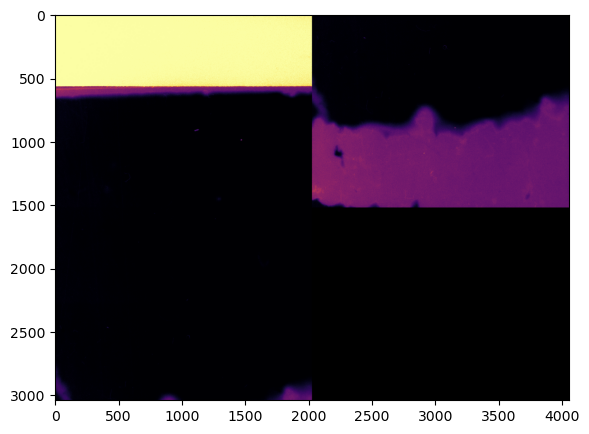

Not enough keypoints or matches. Using 50% overlap for stitching.


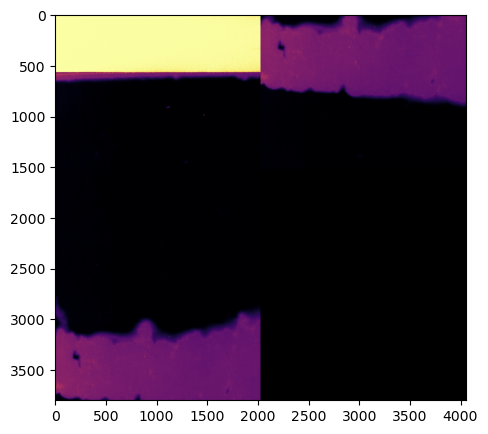

Not enough keypoints or matches. Using 50% overlap for stitching.


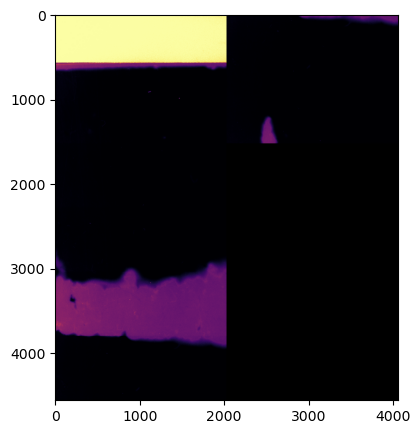

Not enough keypoints or matches. Using 50% overlap for stitching.


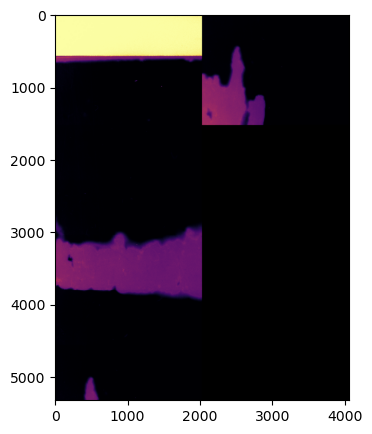

Not enough keypoints or matches. Using 50% overlap for stitching.


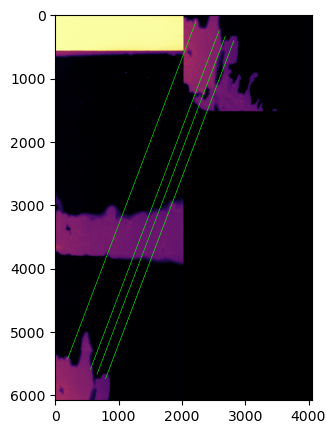

Not enough keypoints or matches. Using 50% overlap for stitching.


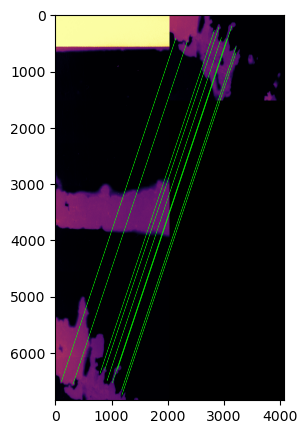

Not enough keypoints or matches. Using 50% overlap for stitching.


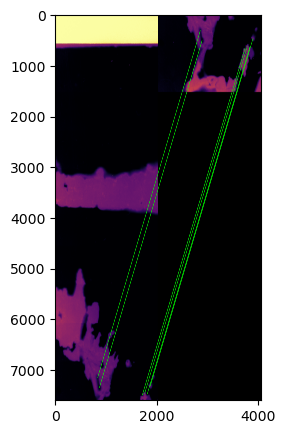

Not enough keypoints or matches. Using 50% overlap for stitching.


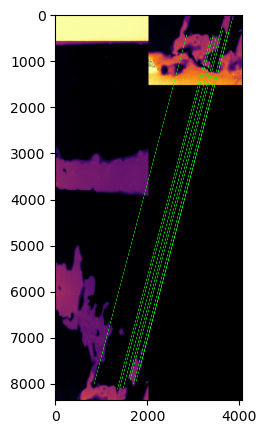

Not enough keypoints or matches. Using 50% overlap for stitching.


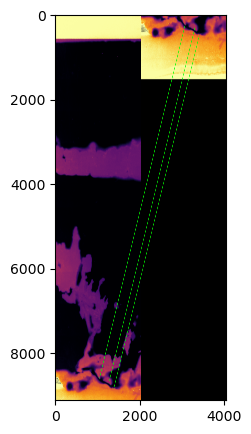

Not enough keypoints or matches. Using 50% overlap for stitching.


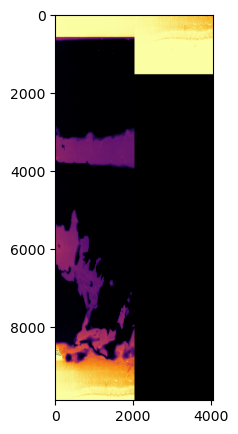

Not enough keypoints or matches. Using 50% overlap for stitching.


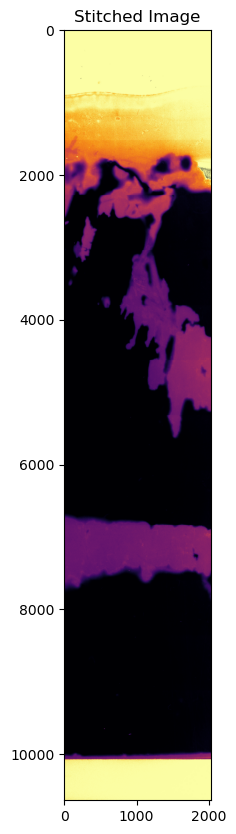

In [15]:
# Load images from the folder and naturally sort them
folder = "E:/Garmisch_data_april-june/Measurement_Images/Test_set_2/RAW_2024-04-26_subset/False_color"
images = load_images_from_folder(folder)

if len(images) > 0:
    final_stitched_image = vertical_stitching_sequential(images)

    # Flip the final stitched image by 180 degrees
    final_stitched_image_flipped = np.flipud(np.fliplr(final_stitched_image))

    # Display the flipped stitched image using Matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(final_stitched_image_flipped)  # Display the RGB image
    plt.title('Stitched Image')

    # Save the flipped stitched image
    plt.savefig("final_stitched_image_flipped.png", dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

    # Save the flipped stitched image as a TIFF file
    tiff_file_path = "E:/Garmisch_data_april-june/Measurement_Images/Test_set_2/RAW_2024-04-26_subset/stitched_image_flipped.tiff"
    cv2.imwrite(tiff_file_path, cv2.cvtColor(final_stitched_image_flipped, cv2.COLOR_BGR2RGB))

else:
    print("No images found in the folder.")


In [ ]:
def process_batch_folders(base_folder):
    """Process all subset folders within a base folder."""
    subset_folders = [os.path.join(base_folder, d) for d in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, d))]

    for subset_folder in subset_folders:
        false_color_folder = os.path.join(subset_folder, 'False_color')
        if os.path.exists(false_color_folder):
            print(f"Processing folder: {false_color_folder}")
            images = load_images_from_folder(false_color_folder)

            if len(images) > 0:
                final_stitched_image = vertical_stitching_sequential(images)

                if final_stitched_image is not None:
                    # Flip the final stitched image by 180 degrees
                    final_stitched_image_flipped = np.flipud(np.fliplr(final_stitched_image))

                    # Display the flipped stitched image using Matplotlib
                    plt.figure(figsize=(10, 10))
                    plt.imshow(final_stitched_image_flipped)
                    plt.title('Stitched Image')
                    plt.show()

                    # Save the flipped stitched image as PNG in the respective subset folder
                    output_image_name = os.path.basename(subset_folder) + "_stitched_flipped.png"
                    output_image_path = os.path.join(subset_folder, output_image_name)
                    plt.savefig(output_image_path, dpi=300, bbox_inches='tight', pad_inches=0)
                    print(f"Saved stitched image to {output_image_path}")

                    # Save the flipped stitched image as a TIFF file in the respective subset folder
                    tiff_file_path = os.path.join(subset_folder, os.path.basename(subset_folder) + "_stitched_flipped.tiff")
                    cv2.imwrite(tiff_file_path, cv2.cvtColor(final_stitched_image_flipped, cv2.COLOR_BGR2RGB))
                    print(f"Saved stitched image as TIFF to {tiff_file_path}")
                else:
                    print(f"Stitching failed for folder: {false_color_folder}")
            else:
                print(f"No images found in folder: {false_color_folder}")
        else:
            print(f"False_color folder not found in subset: {subset_folder}")

# Base folder containing all subset folders with images inside False_color subfolders
base_folder = "E:/Garmisch_data_april-june/Measurement_Images/Test_set_2/"

# Process all subset folders in batch mode
process_batch_folders(base_folder)
